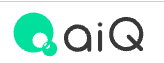

[disclaimer](../../disclaimer.txt/)

# aiQ DataHub: aiQ POS Csmr Goods Evaluation Notebook
- aiQ POS Csmr Goods consolidates sales data for products sold in retail stores such as supermarkets, drugstores, and convenience stores, organized by TICKER.
- Prescription medications, fresh foods without barcodes, and other similar items are not included in the product coverage.

In [1]:
# Commands to automatically update custom modules.
%load_ext autoreload
%autoreload 2

## Step1: Import Library

In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import plotly.io
from aiq_strategy_robot.data.data_accessor import DAL

for_html = False
if for_html:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

if '../..' not in sys.path:
    sys.path.append('../..')

from libs.dataset import aiq_pos_csmr_goods as sc_goods
from libs.dataset import common as sc_common
from libs.path import DEFAULT_DIR

- Create an instance of the standard data handler.
- The data handler is an object that holds libraries for data retrieval and data processing.

In [3]:
sdh = DAL()

## Step2: Load Data to `sdh`
Since the focus here is on demonstrating data analysis, the data will be loaded through a simple loader that has been prepared separately.

In [4]:
sdh.extract.clear()

# Register various demo data into the data handler (`sdh`).
data_id_alt = sc_goods.register_csmr_goods_data(sdh, data_dir=DEFAULT_DIR)
data_id_mkt = sc_common.register_market(sdh)
data_id_funda = sc_common.register_fundamental(sdh)

# Check the registered `data_id`.
display(sdh.extract_definition)

category data_source   source    table           alias  \
data_id                                                          
1        RawData    external   sample  Unknown  pos_csmr_goods   
2        RawData    External  Unknown  Unknown  market_returns   
3        RawData    External  Unknown  Unknown           funda   

                                                   tickers  \
data_id                                                      
1        [1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...   
2        [1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...   
3        [1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...   

                      index       start_datetime         end_datetime  
data_id                                                                
1        [TICKER, DATETIME]  2008-03-16 00:00:00  2024-09-29 00:00:00  
2        [TICKER, DATETIME]  2000-01-04 00:00:00  2024-10-16 00:00:00  
3        [TICKER, DATETIME]  2007-04-20 00:00:00  2024-05-31 00:00:00

In [5]:
# Randomly select a TICKER to use as a sample for plotting.
sample_target = "2281"

In [6]:
display(sdh.get_raw_data(data_id_alt).tail())
display(sdh.get_raw_data(data_id_mkt).tail())
display(sdh.get_raw_data(data_id_funda).tail())

VARIABLE           pos_sales     share  unit_price  unit_price_vs_ind
TICKER DATETIME                                                      
9997   2024-09-01   0.003606  0.000201    0.822752           0.580583
       2024-09-08   0.004539  0.000251    1.004957           0.707059
       2024-09-15   0.002677  0.000148    0.992262           0.700182
       2024-09-22   0.004025  0.000218    1.040915           0.729593
       2024-09-29   0.003051  0.000161    0.950448           0.679405

returns
TICKER DATETIME            
9997   2024-10-10  0.004079
       2024-10-11  0.005413
       2024-10-15 -0.010855
       2024-10-16 -0.010974
       NaT              NaN

sales_yoy
TICKER DATETIME             
9997   2023-03-31   0.008141
       2023-06-30  -0.030340
       2023-09-30  -0.024041
       2023-12-31  -0.024655
       2024-03-31   0.001886

> If you want to use your own financial data with the handler, please set the following flag to True. <br> Note that the sample financial data has already been adjusted for YoY.

In [7]:
USE_MY_FUNDA = False 

> If you want to use your own market data with the handler, please set the following flag to True. <br> Note that the sample market data has already been adjusted for Returns.

In [8]:
USE_MY_MKT = False 

## Step3: Correlation Analysis

### Create `AltDataEvaluator`
Given the nature of aiQ POS Csmr Goods data, it is expected that there is a correlation with financial data (quarterly sales).

We will test this hypothesis here to determine its validity.

#### The `AltDataEvaluator` will be used for evaluating alternative data.

In [9]:
from aiq_strategy_robot.evaluator import AltDataEvaluator

# Initialize AltDataEvaluator
ade = AltDataEvaluator(sdh)

# Configure the settings so that the calculation process logs are not output. (Setting it to True will enable logging)
sdh.transform.verbose = False

#### Retrieve the features from aiQ POS Csmr Goods and store them for later use.

In [10]:
features = sdh.get_raw_data(data_id_alt).columns
features

Index(['pos_sales', 'share', 'unit_price', 'unit_price_vs_ind'], dtype='object', name='VARIABLE')

#### Compare the quarterly sales data loaded in Step 2 with the `pos_sales` from POS Csmr Goods
- To make the comparison possible, resample the `pos_sales` data to match the frequency of the quarterly sales data.

In [11]:
sdh.transform.clear()
funda_Q_ids = sdh.transform.raw(data_id=data_id_funda).variable_ids
alt_Q_ids = sdh.transform.resample_by(label=funda_Q_ids[0], func='mean', data_id=data_id_alt).variable_ids

## Step 3.1: Plotting with Quarterly Sales

Plot the quarterly sales data alongside the alternative data to visually inspect the data shapes.
> It is recommended to compare with your own financial data before applying YoY adjustments.

#### Create Variables from the Base `variable` and Visually Identify Which Matches the Financial Data
- By using `sdh.transform`, you can create various variables and quickly evaluate which one has the strongest relationship with the financial data.
- For a list of `transform` processes, please refer to the sample notebook provided with the `data handler`.

In [12]:
if USE_MY_FUNDA:

    # Plot the data to visually inspect its shape.
    sdh.show_line_one_target(
        target=sample_target, # Decide which TICKER's data to plot.
        y=funda_Q_ids[0], # Specify the data to be displayed on the y-axis using the `variable_id`.
        X= alt_Q_ids, # Specify the data to be displayed on the x-axis using a list of `variable_id`s (use a list when displaying multiple graphs simultaneously).
        col_num=2, # Decide how many graphs to display in a single row.
        vname_len_limit=30, # The title will display the variable names of the X `variable_id`s, but you can specify a character limit to shorten the display.
    )
    
    # Use `resample_by` to resample the data so that it is aggregated according to the dates of the financial data.
    alt_Q_shift_1_ids = sdh.transform.shift(data_id=data_id_alt, periods=1).resample_by(label=funda_Q_ids[0], func='mean').variable_ids
    alt_Q_shift_2_ids = sdh.transform.shift(data_id=data_id_alt, periods=2).resample_by(label=funda_Q_ids[0], func='mean').variable_ids
    alt_Q_shift_3_ids = sdh.transform.shift(data_id=data_id_alt, periods=3).resample_by(label=funda_Q_ids[0], func='mean').variable_ids
    alt_Q_shift_4_ids = sdh.transform.shift(data_id=data_id_alt, periods=4).resample_by(label=funda_Q_ids[0], func='mean').variable_ids

    # View Sales vs Pos Sales
    sdh.show_line_one_target(
        target=sample_target,
        y=funda_Q_ids[0],
        X=[alt_Q_shift_1_ids[0], alt_Q_shift_2_ids[0], 
           alt_Q_shift_3_ids[0], alt_Q_shift_4_ids[0]],
        col_num=2
    )

    # For the next step, calculate the year-over-year (YoY) change and create a variable with an additional lagged difference to address cases where trends might cause apparent correlations.
    sales_id = sdh.transform.log_diff(fields=funda_Q_ids, periods=4).diff(periods=1).variable_ids[-1]

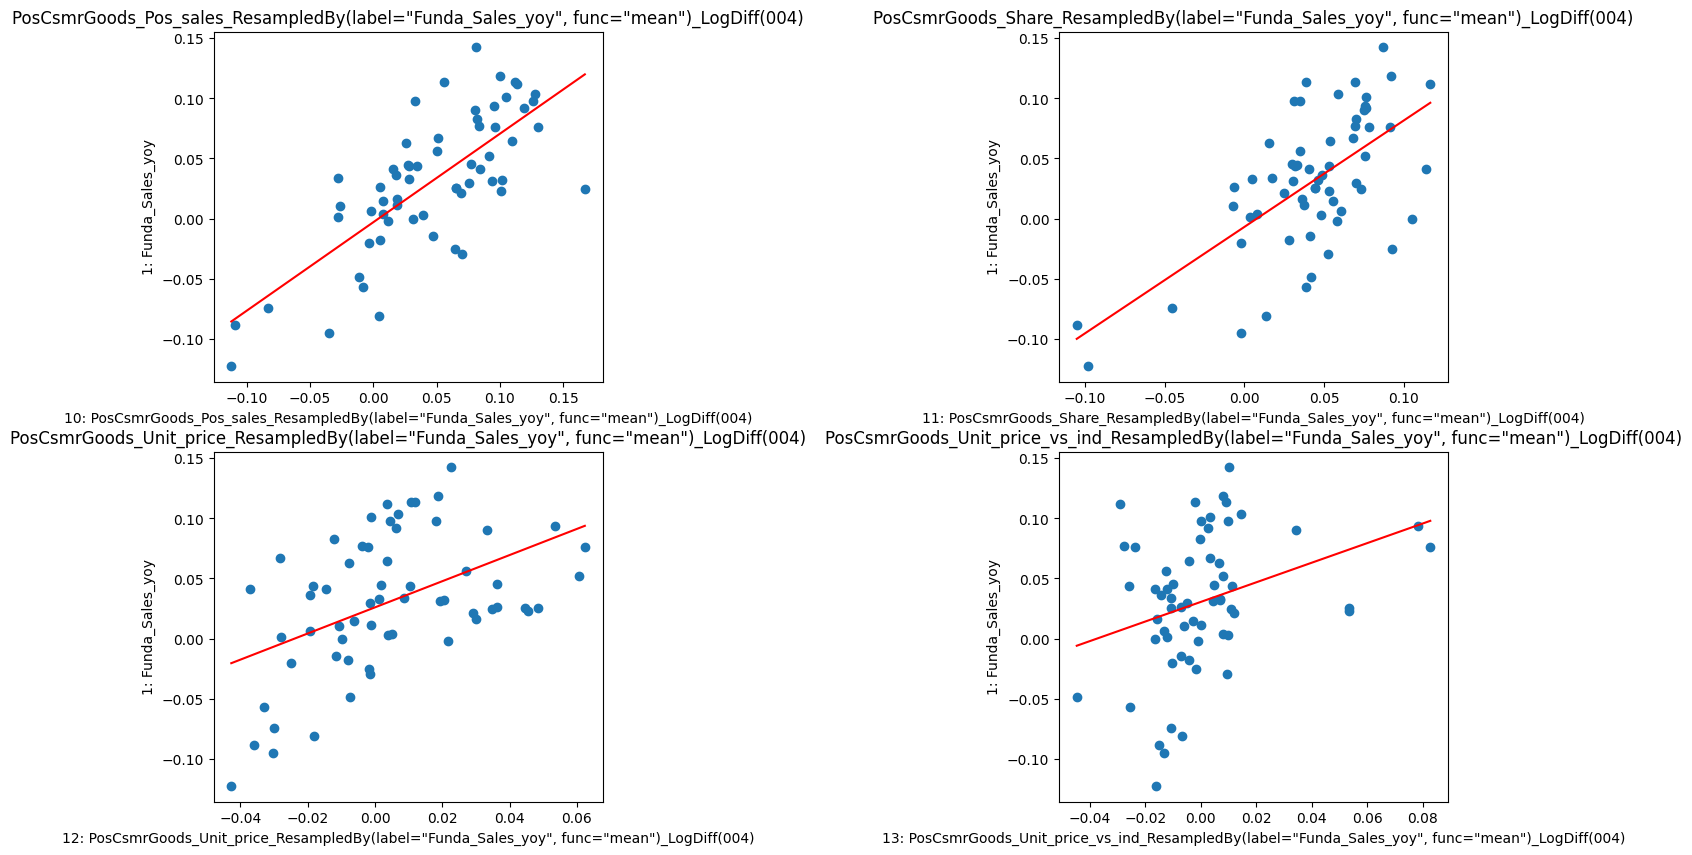

In [13]:
if not USE_MY_FUNDA:
    
    # Convert `pos_sales` to YoY as well for comparison with the financial data.
    alt_Q_yoy_ids = sdh.transform.log_diff(periods=4, fields=alt_Q_ids).variable_ids
    
    # Plot the data to visually inspect its shape.
    sdh.show_scatter_one_target(
        target=sample_target,
        y=funda_Q_ids[0],
        X=alt_Q_yoy_ids,
        col_num=2
    )

    # Use `resample_by` to resample the data so that it is aggregated according to the dates of the financial data.
    alt_Q_shift_1_ids = sdh.transform.shift(data_id=data_id_alt, periods=1).resample_by(label=funda_Q_ids[0], func='mean').variable_ids
    alt_Q_shift_2_ids = sdh.transform.shift(data_id=data_id_alt, periods=2).resample_by(label=funda_Q_ids[0], func='mean').variable_ids
    alt_Q_shift_3_ids = sdh.transform.shift(data_id=data_id_alt, periods=3).resample_by(label=funda_Q_ids[0], func='mean').variable_ids
    alt_Q_shift_4_ids = sdh.transform.shift(data_id=data_id_alt, periods=4).resample_by(label=funda_Q_ids[0], func='mean').variable_ids

    # To address cases where trends might cause apparent correlations, create a variable with an additional lagged difference.
    sales_id = sdh.transform.diff(fields=funda_Q_ids, periods=1).variable_ids[-1]

#### Verify using variables that have been lagged with the first difference of the alternative data features.

In [14]:
alt_Q_shift_0_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_1_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_shift_1_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_2_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_shift_2_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_3_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_shift_3_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_4_logdiff_ids = sdh.transform.log_diff(fields=alt_Q_shift_4_ids, periods=4).diff(periods=1).variable_ids

# Check application of method chain.
sdh.transform.show_method_chain()

data_id       variable_id step_001  \
process_id                                       
13                3              [46]    raw()   
14                1  [47, 48, 49, 50]    raw()   
16                1  [55, 56, 57, 58]        -   
18                1  [63, 64, 65, 66]        -   
20                1  [71, 72, 73, 74]        -   
22                1  [79, 80, 81, 82]        -   

                                                     step_002  \
process_id                                                      
13                                            diff(periods=1)   
14          resample_by(label="Funda_Sales_yoy", func="mean")   
16          resample_by(label="Funda_Sales_yoy", func="mean")   
18          resample_by(label="Funda_Sales_yoy", func="mean")   
20          resample_by(label="Funda_Sales_yoy", func="mean")   
22          resample_by(label="Funda_Sales_yoy", func="mean")   

                       step_003         step_004  
process_id                                        
13                                                
14          log_diff(periods=4)  diff(periods=1)  
16          log_diff(periods=4)  diff(periods=1)  
18          log_diff(periods=4)  diff(periods=1)  
20          log_diff(periods=4)  diff(periods=1)  
22          log_diff(periods=4)  diff(periods=1)

#### Execute the correlation calculations one by one.

In [15]:
rho_pool = pd.DataFrame()
rho_pool['n_shift=0'] = ade.compu_rho(alt_Q_shift_0_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=1'] = ade.compu_rho(alt_Q_shift_1_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=2'] = ade.compu_rho(alt_Q_shift_2_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=3'] = ade.compu_rho(alt_Q_shift_3_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=4'] = ade.compu_rho(alt_Q_shift_4_logdiff_ids, sales_id, rename_features=features)
display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

n_shift=0  n_shift=1  n_shift=2  n_shift=3  n_shift=4
pos_sales          14.313396  11.316954   8.413976   5.932159   4.769389
share               5.059071   4.395785   3.592493   2.625311   3.562496
unit_price_vs_ind   1.427204   1.023652   0.415687  -0.299486  -0.735402
unit_price          0.051041  -1.004597  -1.668304  -2.579399  -2.617638

In [16]:
# Retrieve the results from the contents of the pooled DataFrame.
display(rho_pool.xs('rho', level=1).sort_values(rho_pool.columns[0], ascending=False))

n_shift=0  n_shift=1  n_shift=2  n_shift=3  n_shift=4
pos_sales           0.123923   0.098293   0.073251   0.052040   0.041871
share               0.044098   0.038337   0.031345   0.023056   0.031288
unit_price_vs_ind   0.012451   0.008934   0.003629  -0.002631  -0.006462
unit_price          0.000445  -0.008767  -0.014562  -0.022653  -0.022995

#### Correlation values can also be calculated on a Ticker-by-Ticker basis
- Below, the top 5 TICKERs are selected, and their relationships are plotted.

In [17]:
rho_time = ade.compu_rho(alt_Q_shift_1_logdiff_ids, sales_id, by='ticker', rename_features=features)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

pos_sales     share  unit_price  unit_price_vs_ind
TICKER                                                    
2226     9.500869  6.554818   -0.042537           0.298083
2220     7.280671  5.711003   -0.434502          -1.965568
2804     6.135112  0.524333    1.046190          -1.138697
2208     5.889190  1.437646    2.672743           1.524452
2908     5.538624  0.398367    0.781101           0.905671

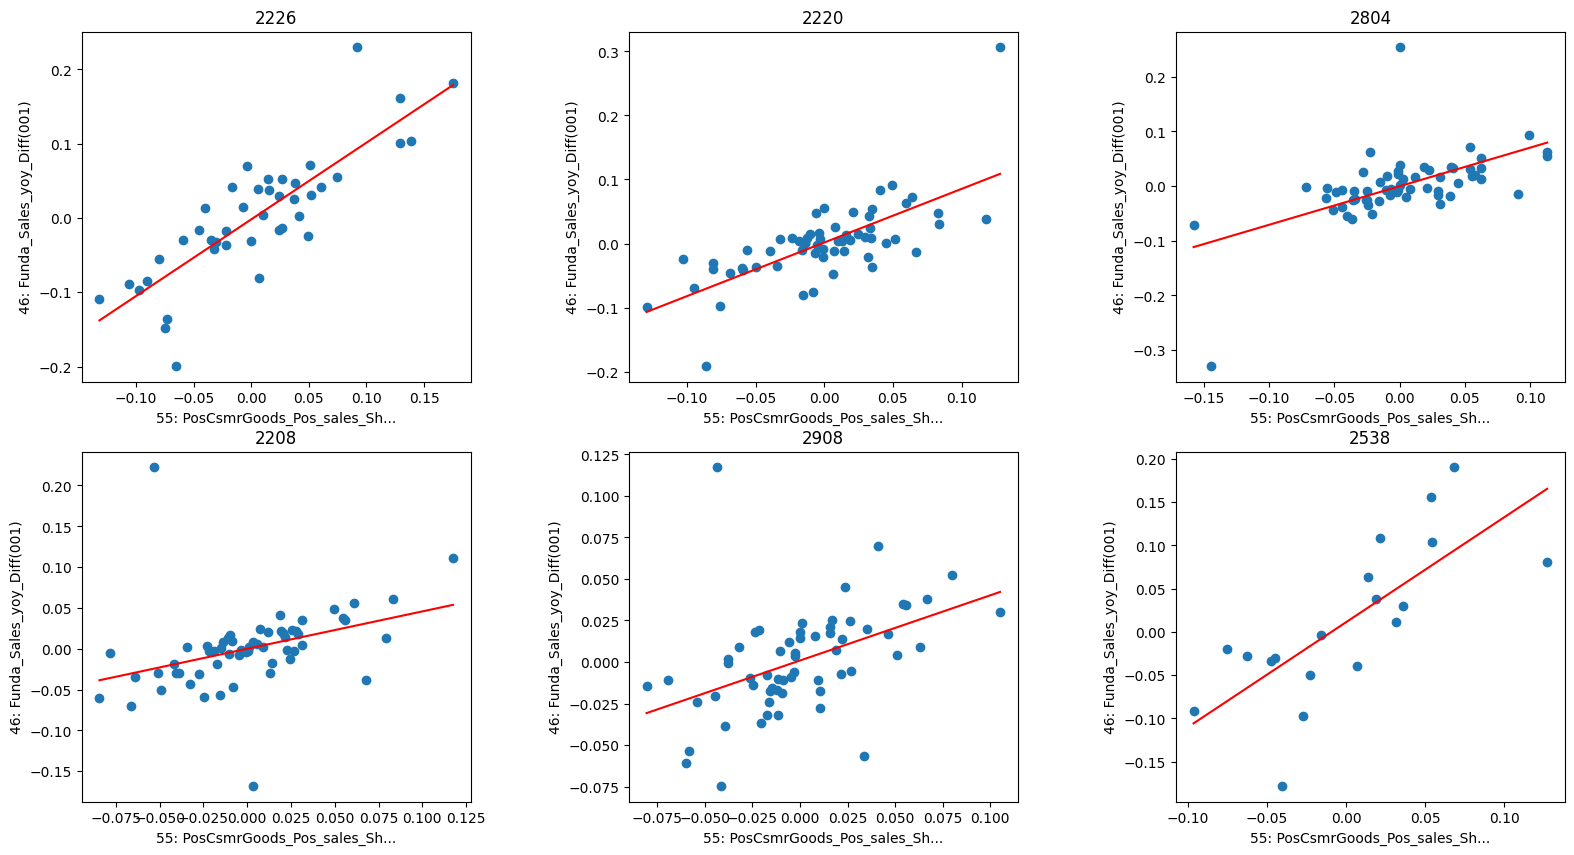

In [18]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=sales_id,
    x=alt_Q_shift_1_logdiff_ids[0],
    targets=top6tickers,
    col_num=3,
    vname_len_limit=25,
)

### Step 3.2: Correlation with Stock Price Changes
- Having confirmed a strong relationship between financial data and POS Csmr Goods, the next step is to examine the correlation with stock price changes.
- To align the stock price data with the POS data, resample it to weekly data for comparison.

In [19]:
if USE_MY_MKT:
     mkt_W_close_id = sdh.transform.resample(data_id=data_id_mkt, rule='W', fields='close', func='last').variable_ids[-1]
else:
     mkt_W_close_id = sdh.transform.fillna(0, data_id=data_id_mkt, fields='returns').cumsum().resample(rule='W', func='last').variable_ids[-1]


alt_ids = sdh.transform.raw(data_id=data_id_alt).variable_ids
alt_ids += sdh.transform.mul(data_id=data_id_alt, x1field='pos_sales', x2field='unit_price').variable_ids
alt_W_ids = sdh.transform.resample(rule='W', func='mean', fields=alt_ids).variable_ids

In [20]:
features = sdh.get_raw_data(data_id_alt).columns.to_list() + ['pos_sales*uprice']

#### Plotting with Stock Prices

Similar to the comparison with financial data, plot the data to understand its shape and structure.

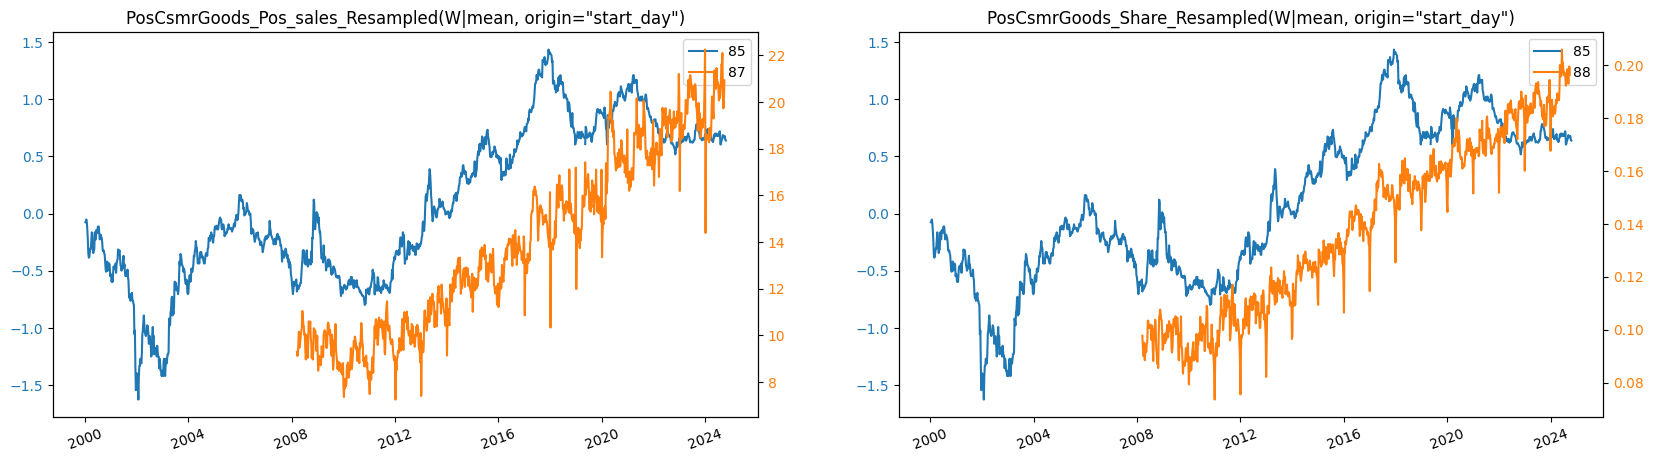

In [21]:
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_W_close_id,
    X=alt_W_ids[:2],
    col_num=2
)

##### Explore the Optimal Shift Interval in the Same Way as the Comparison with Financial Data

In [22]:
alt_W_shift_0_ids = sdh.transform.sma(fields=alt_W_ids, periods=12).variable_ids
alt_W_shift_1_ids = sdh.transform.shift(fields=alt_ids, periods=1).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_2_ids = sdh.transform.shift(fields=alt_ids, periods=2).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_3_ids = sdh.transform.shift(fields=alt_ids, periods=3).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_4_ids = sdh.transform.shift(fields=alt_ids, periods=4).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_5_ids = sdh.transform.shift(fields=alt_ids, periods=5).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_6_ids = sdh.transform.shift(fields=alt_ids, periods=6).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_7_ids = sdh.transform.shift(fields=alt_ids, periods=7).resample(rule='W', func='mean').sma(periods=12).variable_ids
alt_W_shift_8_ids = sdh.transform.shift(fields=alt_ids, periods=8).resample(rule='W', func='mean').sma(periods=12).variable_ids

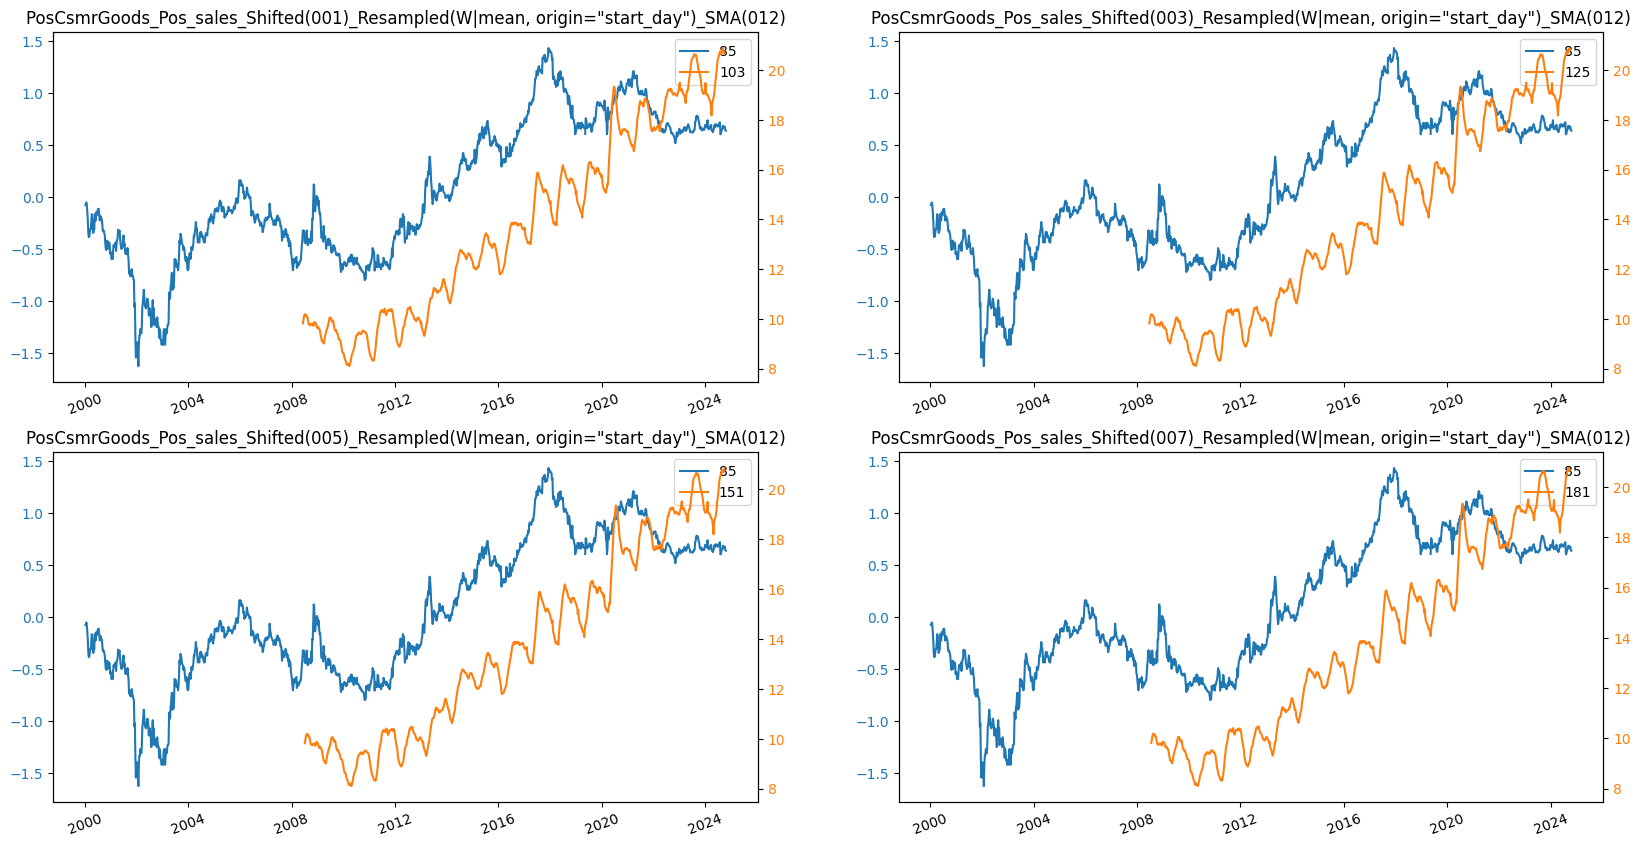

In [23]:
# View Sales vs Pos Sales
sdh.show_line_one_target(
    target=sample_target,
    y=mkt_W_close_id,
    X=[alt_W_shift_1_ids[0], alt_W_shift_3_ids[0], 
       alt_W_shift_5_ids[0], alt_W_shift_7_ids[0]],
    col_num=2
)

> Make `return`

In [24]:
if USE_MY_MKT:
    close_ret = sdh.transform.dropna(fields=mkt_W_close_id, how='all').log_diff(periods=1, names='ret').variable_ids[-1]
else:
    close_ret = sdh.transform.dropna(fields=mkt_W_close_id, how='all').diff(periods=1, names='ret').variable_ids[-1]

> Calculate the year-over-year (YoY) change for the same week before performing the correlation analysis.

In [25]:
alt_W_shift_0_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_0_ids, periods=52).variable_ids
alt_W_shift_1_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_1_ids, periods=52).variable_ids
alt_W_shift_2_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_2_ids, periods=52).variable_ids
alt_W_shift_3_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_3_ids, periods=52).variable_ids
alt_W_shift_4_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_4_ids, periods=52).variable_ids
alt_W_shift_5_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_5_ids, periods=52).variable_ids
alt_W_shift_6_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_6_ids, periods=52).variable_ids
alt_W_shift_7_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_7_ids, periods=52).variable_ids
alt_W_shift_8_sma12_logdiff_ids = sdh.transform.log_diff(fields=alt_W_shift_8_ids, periods=52).variable_ids

# Check the Method Chain
sdh.transform.show_method_chain()

data_id           variable_id           step_001  \
process_id                                                     
13                3                  [46]              raw()   
14                1      [47, 48, 49, 50]              raw()   
16                1      [55, 56, 57, 58]                  -   
18                1      [63, 64, 65, 66]                  -   
20                1      [71, 72, 73, 74]                  -   
22                1      [79, 80, 81, 82]                  -   
54                2                 [202]  fillna(value=0.0)   
55                1  [203, 204, 205, 206]                  -   
55                1                 [207]                ...   
56                1  [208, 209, 210, 211]                  -   
56                1                 [212]                ...   
57                1  [213, 214, 215, 216]                  -   
57                1                 [217]                ...   
58                1  [218, 219, 220, 221]                  -   
58                1                 [222]                ...   
59                1  [223, 224, 225, 226]                  -   
59                1                 [227]                ...   
60                1  [228, 229, 230, 231]                  -   
60                1                 [232]                ...   
61                1  [233, 234, 235, 236]                  -   
61                1                 [237]                ...   
62                1  [238, 239, 240, 241]                  -   
62                1                 [242]                ...   
63                1  [243, 244, 245, 246]                  -   
63                1                 [247]                ...   

                                                     step_002  \
process_id                                                      
13                                            diff(periods=1)   
14          resample_by(label="Funda_Sales_yoy", func="mean")   
16          resample_by(label="Funda_Sales_yoy", func="mean")   
18          resample_by(label="Funda_Sales_yoy", func="mean")   
20          resample_by(label="Funda_Sales_yoy", func="mean")   
22          resample_by(label="Funda_Sales_yoy", func="mean")   
54                                                   cumsum()   
55                                                          -   
55                                               mul(raw|raw)   
56                                                          -   
56                                               mul(raw|raw)   
57                                                          -   
57                                               mul(raw|raw)   
58                                                          -   
58                                               mul(raw|raw)   
59                                                          -   
59                                               mul(raw|raw)   
60                                                          -   
60                                               mul(raw|raw)   
61                                                          -   
61                                               mul(raw|raw)   
62                                                          -   
62                                               mul(raw|raw)   
63                                                          -   
63                                               mul(raw|raw)   

                                                       step_003  \
process_id                                                        
13                                                                
14                                          log_diff(periods=4)   
16                                          log_diff(periods=4)   
18                                          log_diff(periods=4)   
20                                          log_diff(periods=4)   
22                                          log_diff(perio

> Calculate the correlation coefficient and its T-value.

In [26]:
rho_pool = pd.DataFrame()
rho_pool['n_shift=0, sma=12'] = ade.compu_rho(alt_W_shift_0_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=1, sma=12'] = ade.compu_rho(alt_W_shift_1_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=2, sma=12'] = ade.compu_rho(alt_W_shift_2_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=3, sma=12'] = ade.compu_rho(alt_W_shift_3_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=4, sma=12'] = ade.compu_rho(alt_W_shift_4_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=5, sma=12'] = ade.compu_rho(alt_W_shift_5_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=6, sma=12'] = ade.compu_rho(alt_W_shift_6_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=7, sma=12'] = ade.compu_rho(alt_W_shift_7_sma12_logdiff_ids, close_ret, rename_features=features)
rho_pool['n_shift=8, sma=12'] = ade.compu_rho(alt_W_shift_8_sma12_logdiff_ids, close_ret, rename_features=features)

display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

n_shift=0, sma=12  n_shift=1, sma=12  n_shift=2, sma=12  \
pos_sales                   6.758596           6.895769           6.381051   
pos_sales*uprice            5.907409           6.144259           5.991720   
share                       3.392203           3.368502           3.016674   
unit_price                  0.628347           0.702423           0.864604   
unit_price_vs_ind           0.037907          -0.001404           0.264464   

                   n_shift=3, sma=12  n_shift=4, sma=12  n_shift=5, sma=12  \
pos_sales                   6.402048           6.268956           5.751145   
pos_sales*uprice            6.004652           6.067394           5.723561   
share                       2.840014           2.871265           2.619149   
unit_price                  1.045433           1.144163           1.314466   
unit_price_vs_ind           0.434358           0.307920           0.549870   

                   n_shift=6, sma=12  n_shift=7, sma=12  n_shift=8, sma=12  
pos_sales                   5.208143           5.111412           4.602210  
pos_sales*uprice            4.879570           4.835907           4.200773  
share                       2.364486           2.393602           2.153049  
unit_price                  1.031864           0.716238           0.499608  
unit_price_vs_ind           0.199803          -0.126287          -0.276480

> Select the top N Tickers with the highest correlation and visually inspect their relationships using scatter plots.

In [27]:
rho_time = ade.compu_rho(alt_W_shift_1_sma12_logdiff_ids, close_ret, by='ticker', rename_features=features)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

pos_sales     share  unit_price  unit_price_vs_ind  pos_sales*uprice
TICKER                                                                      
5194     3.905556  4.082759    2.364486           2.050038          4.013749
2281     3.332151  3.359696    2.094039           0.769370          3.256184
2212     2.841459  1.506306    0.856403          -0.117824          2.753113
2884     2.775279  0.183751    0.395633           1.712927          2.577629
2216     2.645966  1.266268    1.642839           1.004186          2.810953

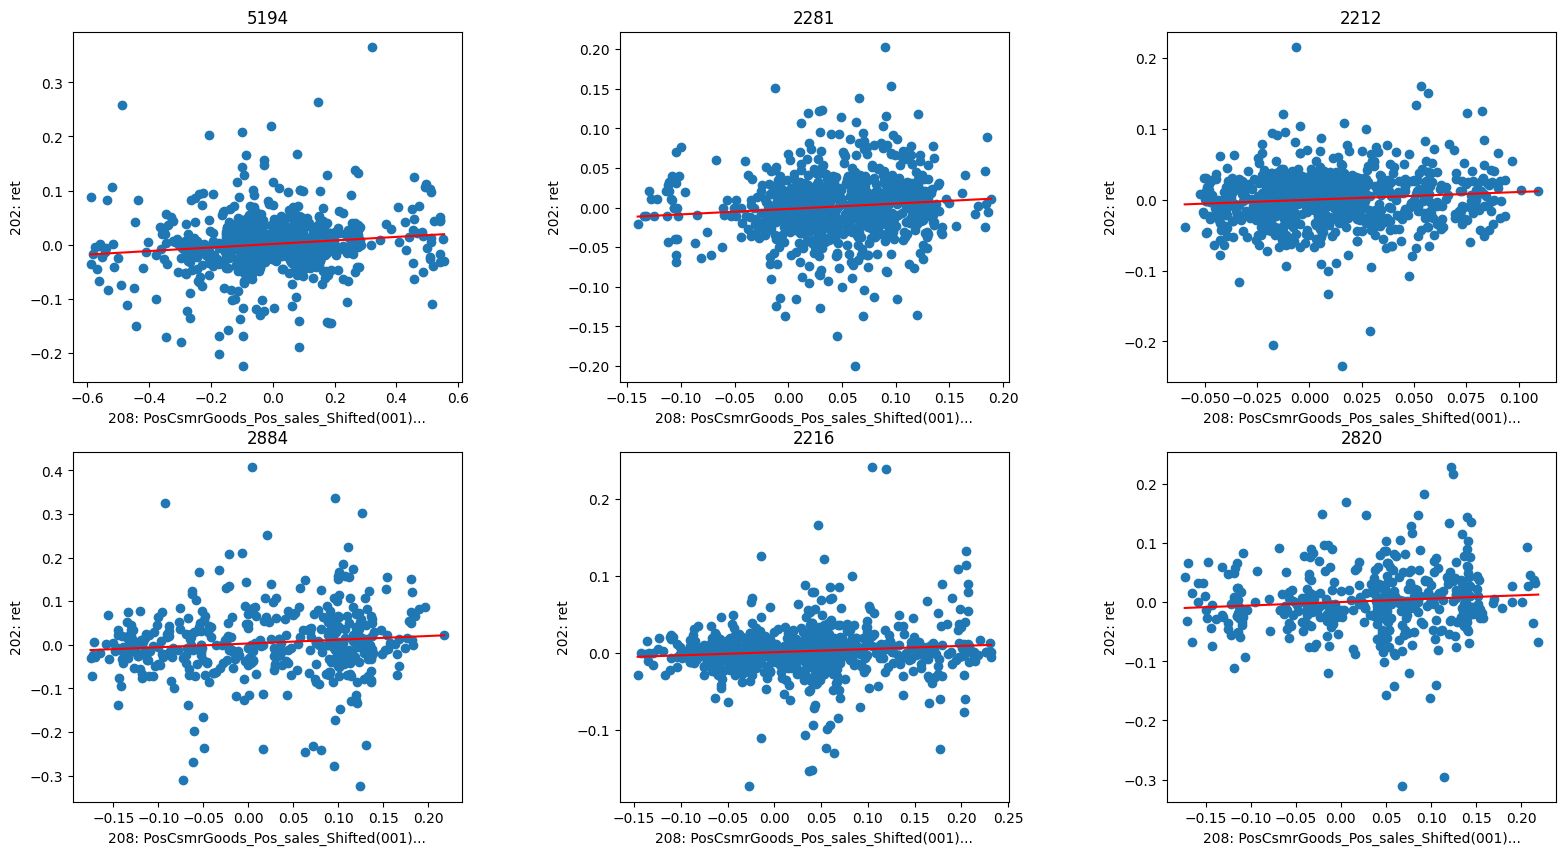

In [28]:
top6tickers = rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:6]

sdh.show_scatter_per_target(
    y=close_ret,
    x=alt_W_shift_1_sma12_logdiff_ids[0],
    targets=top6tickers,
    col_num=3,
    vname_len_limit=35,
)

## Step 4: Quantile Backtest
- Based on the variables created in Step 3, various factors will be generated and calculations will be performed.
- Here, the 12-week moving average of `pos_sales` is selected as the factor value.
- In practice, you should vary hyperparameters such as the moving average period and shift intervals to ensure that the backtest results are not significantly affected.

In [29]:
# Create a tercile (three-quantile) portfolio.
nq = 3

# Assume one-way transaction costs.
exe_cost = 0.0005

In [30]:
# Retrieve the `variable_id` that was calculated in Step 3.
display(sdh.transform.find_variables(alt_W_shift_1_sma12_logdiff_ids))

pos_sales = alt_W_shift_1_sma12_logdiff_ids[0]
pos_sales_and_uprice = alt_W_shift_1_sma12_logdiff_ids[-1]

variable_id  data_id  \
variable_name                                                              
PosCsmrGoods_Pos_sales_Shifted(001)_Resampled(W...          208        1   
PosCsmrGoods_Share_Shifted(001)_Resampled(W|mea...          209        1   
PosCsmrGoods_Unit_price_Shifted(001)_Resampled(...          210        1   
PosCsmrGoods_Unit_price_vs_ind_Shifted(001)_Res...          211        1   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...          212        1   

                                                   data_source  source  \
variable_name                                                            
PosCsmrGoods_Pos_sales_Shifted(001)_Resampled(W...    external  sample   
PosCsmrGoods_Share_Shifted(001)_Resampled(W|mea...    external  sample   
PosCsmrGoods_Unit_price_Shifted(001)_Resampled(...    external  sample   
PosCsmrGoods_Unit_price_vs_ind_Shifted(001)_Res...    external  sample   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...    external  sample   

                                                      table  \
variable_name                                                 
PosCsmrGoods_Pos_sales_Shifted(001)_Resampled(W...  Unknown   
PosCsmrGoods_Share_Shifted(001)_Resampled(W|mea...  Unknown   
PosCsmrGoods_Unit_price_Shifted(001)_Resampled(...  Unknown   
PosCsmrGoods_Unit_price_vs_ind_Shifted(001)_Res...  Unknown   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  Unknown   

                                                                                                field  \
variable_name                                                                                           
PosCsmrGoods_Pos_sales_Shifted(001)_Resampled(W...  PosCsmrGoods_Pos_sales_Shifted(001)_Resampled(...   
PosCsmrGoods_Share_Shifted(001)_Resampled(W|mea...  PosCsmrGoods_Share_Shifted(001)_Resampled(W|me...   
PosCsmrGoods_Unit_price_Shifted(001)_Resampled(...  PosCsmrGoods_Unit_price_Shifted(001)_Resampled...   
PosCsmrGoods_Unit_price_vs_ind_Shifted(001)_Res...  PosCsmrGoods_Unit_price_vs_ind_Shifted(001)_Re...   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_p...   

                                                   ticker  reference_id  \
variable_name                                                             
PosCsmrGoods_Pos_sales_Shifted(001)_Resampled(W...   None           103   
PosCsmrGoods_Share_Shifted(001)_Resampled(W|mea...   None           104   
PosCsmrGoods_Unit_price_Shifted(001)_Resampled(...   None           105   
PosCsmrGoods_Unit_price_vs_ind_Shifted(001)_Res...   None           106   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...   None           107   

                                                   variable_type    method  \
variable_name                                                                
PosCsmrGoods_Pos_sales_Shifted(001)_Resampled(W...       feature  log_diff   
PosCsmrGoods_Share_Shifted(001)_Resampled(W|mea...     reference  log_diff   
PosCsmrGoods_Unit_price_Shifted(001)_Resampled(...     reference  log_diff   
PosCsmrGoods_Unit_price_vs_ind_Shifted(001)_Res...     reference  log_diff   
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...     reference  log_diff   

                                                        params  process_id  
variable_name                                                               
PosCsmrGoods_Pos_sales_Shifted(001)_Resampled(W...  periods=52          56  
PosCsmrGoods_Share_Shifted(001)_Resampled(W|mea...  periods=52          56  
PosCsmrGoods_Unit_price_Shifted(001)_Resampled(...  periods=52          56  
PosCsmrGoods_Unit_price_vs_ind_Shifted(001)_Res...  periods=52          56  
Mul(PosCsmrGoods_Pos_sales|PosCsmrGoods_Unit_pr...  periods=52          56

### Try pos_sales factor

In [31]:
dfqret, stats, dfsigqt = ade.q_backtest(
    pos_sales,
    close_ret,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R  ann.TurnOver  \
#1           0.397599  0.025947  0.141175  0.183796  0.580726      2.746832   
#2           0.397727  0.025956  0.136049  0.190783  0.559449      5.184328   
#3           1.048463  0.068423  0.139765  0.489555  0.588235      2.741538   
#3-#1        0.650864  0.042475  0.047179  0.900310  0.573217      5.488371   
#3-#1(cost)  0.608867  0.039735  0.047179  0.842209  0.568210      5.488371   

               Max_DD  Calmar Ratio  
#1          -0.502545      0.051632  
#2          -0.446949      0.058073  
#3          -0.440364      0.155378  
#3-#1       -0.080049      0.530618  
#3-#1(cost) -0.080896      0.491181

### We try pos_sales * unit_price composite factor too

In [32]:
dfqret, stats, dfsigqt = ade.q_backtest(
    pos_sales_and_uprice,
    close_ret,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

cum.Ret   ann.Ret   ann.Std       R/R     Win_R  ann.TurnOver  \
#1           0.342993  0.022384  0.136312  0.164210  0.578223      3.012333   
#2           0.615895  0.040193  0.137425  0.292475  0.569462      5.500629   
#3           0.886267  0.057838  0.142318  0.406399  0.583229      2.865246   
#3-#1        0.543273  0.035454  0.045255  0.783433  0.553191      5.877579   
#3-#1(cost)  0.498298  0.032519  0.045260  0.718491  0.551940      5.877579   

               Max_DD  Calmar Ratio  
#1          -0.487532      0.045912  
#2          -0.433906      0.092632  
#3          -0.468652      0.123413  
#3-#1       -0.086619      0.409313  
#3-#1(cost) -0.090989      0.357393